In [1]:
from rebinning import station_radii, draw_wheels, make_concentric_disks, make_disk, station3_boundaries, rebin,assign_colors
import numpy as np
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader


from drawing_utilities import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using:", device)

You are using: cuda


In [2]:
def Show2DLoss(img, vmin=-1., vmax=3., title='Loss'):
    fig = plt.figure(figsize =(8, 8))
    img_temp = copy.deepcopy(img)
    cmap = plt.cm.jet
    cmap.set_under(color='white')
    img_temp[img_temp==0] = np.nan
    plt.imshow(img_temp, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()
    del img_temp

In [3]:
dir = "/eos/cms/store/group/ml/AD4MVDHackathon/ML4DQM_MUON/anomalies/"
file = "hRHGlobalm2_130824_s1.npz"
data = np.load(dir+file)

In [4]:
#data.files has "bad_flag": 1 for good data, -1 for bad data

data_np = np.array(data["bad_flag"])

good_data_filter = data_np == 1
bad_data_filter = data_np == -1

good_imgs_unbinned = data["no_rebin_imgs"][good_data_filter]
bad_imgs_unbinned = data["no_rebin_imgs"][bad_data_filter]

print(f"Data has {len(bad_imgs_unbinned)} bad images and {len(good_imgs_unbinned)} good images")

Data has 718 bad images and 7754 good images


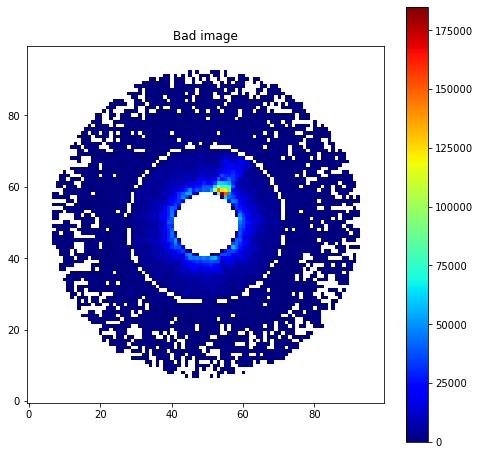

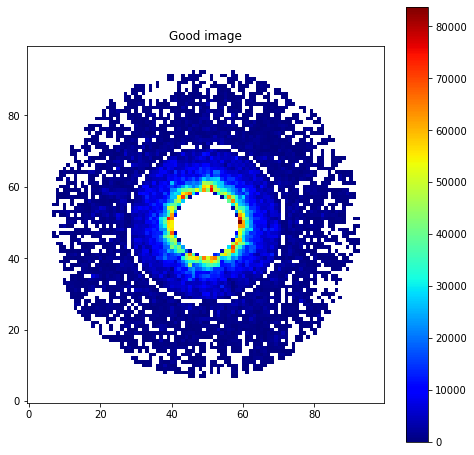

In [5]:
Show2Dimg(bad_imgs_unbinned[0], title="Bad image")
Show2Dimg(good_imgs_unbinned[0], title="Good image")

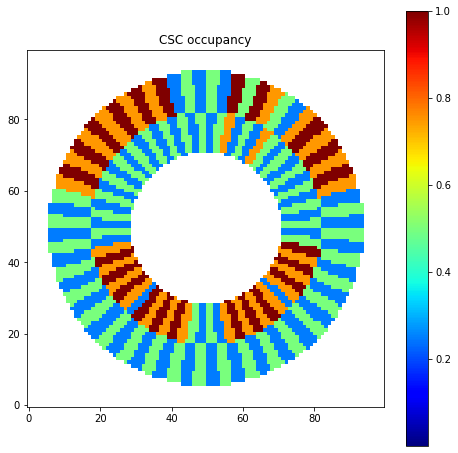

In [6]:
empty_img = np.zeros((100,100), dtype=np.int16)
inner_radius, outer_radius = station3_boundaries()
hole = make_disk(empty_img, inner_radius,1.)
hole = np.abs(hole-1)
hole *= make_disk(empty_img, outer_radius,1.)

slices = draw_wheels(50,2)
conc_disks = make_concentric_disks(50,station_radii(2))
regions = slices * conc_disks * hole
Show2Dimg(assign_colors(regions))
bad_imgs = np.array([rebin(regions, img) for img in bad_imgs_unbinned])
good_imgs = np.array([rebin(regions, img) for img in good_imgs_unbinned])

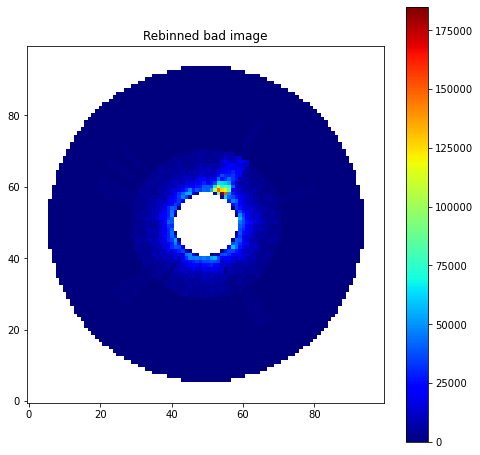

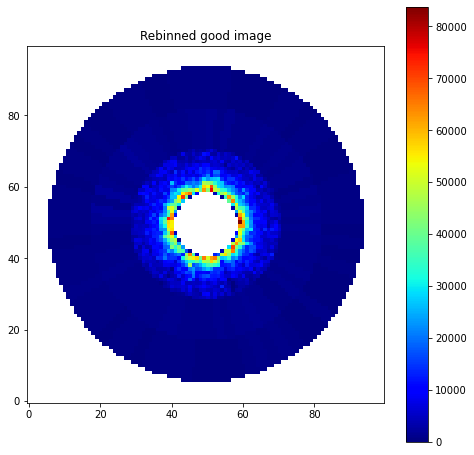

In [7]:
Show2Dimg(bad_imgs[0], title="Rebinned bad image")
Show2Dimg(good_imgs[0], title="Rebinned good image")

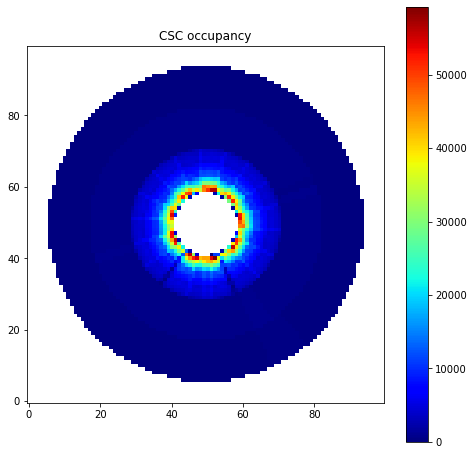

In [8]:
mean_matrix = np.mean(good_imgs, axis=0)
Show2Dimg(mean_matrix)
mean_matrix[mean_matrix == 0] = np.nan

In [9]:
out_label = "240724"
model = torch.load("AAAA.pth")

# Assign labels to the images: 0 for good, 1 for bad
bad_tensor = [[1,(torch.tensor(m, dtype=torch.float32)).unsqueeze(0)] for m in bad_imgs]
good_tensor = [[0,(torch.tensor(m, dtype=torch.float32)).unsqueeze(0)] for m in good_imgs]
mixed_dataset = good_tensor + bad_tensor

# Create a DataLoader for the mixed dataset
mixed_loader = DataLoader(dataset=mixed_dataset,
                          batch_size=1,
                          num_workers=10,
                          shuffle=False)

In [10]:
all_good_losses = []
all_bad_losses = []
for i, (label,img) in enumerate(mixed_loader):
    img = img.to(device)
    reco_img = model(img)
    loss = img - reco_img
    loss = loss[0][0].cpu().detach().numpy() / mean_matrix
    loss = loss.ravel()  # flatten the loss array

    if label == 0:
        all_good_losses.extend(loss) 
    else:
        all_bad_losses.extend(loss) 
all_good_losses = np.array(all_good_losses)
all_bad_losses = np.array(all_bad_losses)

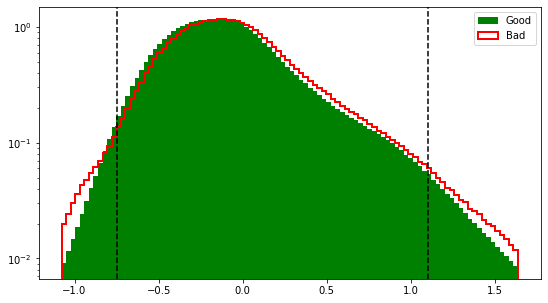

In [11]:
#plot the losses
import matplotlib.pyplot as plt

bad_min, bad_max = np.nanpercentile(all_bad_losses, [0.5, 99.5])
good_min, good_max = np.nanpercentile(all_good_losses, [0.5, 99.5])
x_range = [min(bad_min, good_min), max(bad_max, good_max)]

#values for threshold, which look reasonable by eye
bad_loss_low = -0.75
bad_loss_high = 1.1

fig = plt.figure(figsize =(9,5))
plt.hist(all_good_losses, bins=100, range=x_range, color='green', label='Good', density = True)
plt.hist(all_bad_losses, bins=100, range=x_range, color='red', label='Bad', density = True, histtype='step', linewidth=2)
plt.yscale('log')
#draw a dashed black vertical line at x_low x_high
plt.axvline(bad_loss_low, color='black', linestyle='--')
plt.axvline(bad_loss_high, color='black', linestyle='--')
plt.legend()
plt.show()

In [12]:
import numpy as np
import matplotlib.patches as mpatches


class ImageProcessor:
    _instance = None
    BAD = -1.
    GOOD = 1.

    def __new__(cls, *args, **kwargs):
        if not cls._instance:
            cls._instance = super(ImageProcessor, cls).__new__(cls)
        return cls._instance

    def __init__(self, bad_loss_low, bad_loss_high, radial_regions, mean_matrix):
        self.bad_loss_low = bad_loss_low
        self.bad_loss_high = bad_loss_high
        self.radial_regions = sorted(radial_regions)
        self.shape = mean_matrix.shape
        self.center = [self.shape[0]//2 + 0.5, self.shape[1]//2 + 0.5]
        self.mask = np.where(mean_matrix > 0, self.GOOD, 0.)

    def process_image(self, image):
        image = np.where((image < self.bad_loss_low) | (image > self.bad_loss_high), self.BAD, image)
        image = np.where(image != self.BAD, self.mask , image)
        return image
    

    def plot_image(self, image, title="Image"):
        fig = plt.figure(figsize=(6,6))
        # Create an RGB image with all pixels set to green
        rgb_image = np.ones((image.shape[0], image.shape[1], 3))
        rgb_image[self.mask == self.GOOD] = [0, 1, 0]

        # Set the pixels where image == self.BAD to red
        rgb_image[image == self.BAD] = [1, 0, 0]

        plt.imshow(rgb_image)
        plt.gca().invert_yaxis()
        plt.title(title)

        # Create a red patch for BAD pixels and a green patch for GOOD pixels
        red_patch = mpatches.Patch(color='red', label='BAD')
        green_patch = mpatches.Patch(color='green', label='GOOD')

        # Add the patches to the legend
        plt.legend(handles=[red_patch, green_patch])

        plt.show()

    def calculate_radial_distance(self):
        y, x = np.indices(self.shape)
        return np.sqrt((x - self.center[0])**2 + (y - self.center[1])**2)
    
    def is_bad_image(self, image):
        bad_pixels = self.process_image(image) == self.BAD
        radial_distance = self.calculate_radial_distance()
        regions_status = []
        previous_region = 0
        for region in self.radial_regions:
            region_bad_pixels = bad_pixels & (radial_distance >= previous_region) & (radial_distance < region)
            regions_status.append(np.any(region_bad_pixels))
            previous_region = region
        region_bad_pixels = bad_pixels & (radial_distance >= previous_region)
        regions_status.append(np.any(region_bad_pixels))

        return regions_status

#### Rebinning for inner-disk

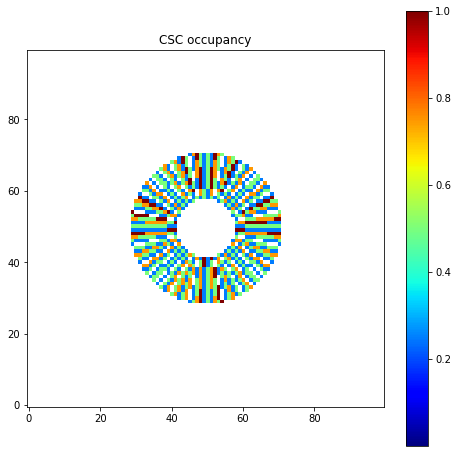

In [13]:
empty_img = np.zeros((100,100), dtype=np.int16)
hole = make_disk(empty_img, 8,1.)
hole = np.abs(hole-1)
inner_slices = draw_wheels(50,4)
disks_radii = np.linspace(8.,inner_radius,2)
hole *= make_disk(empty_img, inner_radius,1.)
inner_disks = make_concentric_disks(50,disks_radii)
inner_regions = inner_slices*inner_disks*hole
Show2Dimg(assign_colors(inner_regions))
#Queste regioni così sono un po' brutte

In [14]:
def calculate_weighted_confusion_matrix(df):
    # Calculate the confusion matrix
    y_true = df['true_label']
    y_pred = df['label']

    n_actually_bad = df['true_label'].sum()
    n_actually_good = len(df) - n_actually_bad

    # Calculate the ratio
    ratio = n_actually_good / n_actually_bad

    # Calculate weights
    weights = df['true_label'].apply(lambda x: 1 if x == 1 else 1/ratio)

    # Calculate weighted confusion matrix
    cm = confusion_matrix(y_true, y_pred, sample_weight=weights)

    # Unpack the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    return tn, fp, fn, tp

In [15]:
image_processor = ImageProcessor(bad_loss_low, bad_loss_high, [21], mean_matrix)


In [16]:
%%time

image_processor = ImageProcessor(bad_loss_low, bad_loss_high, [21], mean_matrix)

frames = []  # List to store DataFrame rows

for i,(label,img) in enumerate(mixed_loader):
    true_label = label[0].item() == 1
    img = img.to(device)
    reco_img = model(img)
    loss = img - reco_img
    loss = loss[0][0].detach().cpu().numpy()
    loss /= mean_matrix
    

    
    img = img[0][0].detach().cpu().numpy()
    reco_img = reco_img[0][0].detach().cpu().numpy()
    
    loss = rebin(inner_regions,loss)
    
    loss = rebin(regions,loss)
    

    # Process the loss image
    loss = image_processor.process_image(loss)

    # Check if the image is good
    label_areas = image_processor.is_bad_image(loss)
    is_bad = np.any(label_areas)
    # Add the information to the DataFrame
    row = {'index': i, 'true_label': true_label}
    for j, bad in enumerate(label_areas):
        row[f'region_{j+1}'] = bad
    frames.append(row)  # Append dictionary to list

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(frames)
df['label'] = df.filter(like='region_').any(axis=1)

CPU times: user 1min 7s, sys: 4.38 s, total: 1min 11s
Wall time: 1min 16s


In [17]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
y_true = df['true_label']
y_pred = df['label']

n_actually_bad = df['true_label'].sum()
n_actually_good = len(df) - n_actually_bad

# Calculate the ratio
ratio = n_actually_good / n_actually_bad

# Calculate weights
weights = df['true_label'].apply(lambda x: 1 if x == 1 else 1/ratio)

# Calculate weighted confusion matrix
cm = confusion_matrix(y_true, y_pred, sample_weight=weights)

# Print the confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f'Weighted true positives: {tp}')
print(f'Weighted false positives: {fp}')
print(f'Weighted true negatives: {tn}')
print(f'Weighted false negatives: {fn}')

# Calculate the fraction of false postives which have bad pixels in region_2
false_negatives = df[(df['true_label'] == False) & (df['label'] == True)]
bad_pixels_in_region_2 = false_negatives[false_negatives['region_2'] == True]
fraction = len(bad_pixels_in_region_2) / len(false_negatives)
# Print the fraction
print(f'Fraction of false negatives which have bad pixels in region_2: {fraction:.2f}')

# Create boolean masks for each condition
tp_mask = (df['true_label'] == True) & (df['label'] == True)
fp_mask = (df['true_label'] == False) & (df['label'] == True)
fn_mask = (df['true_label'] == True) & (df['label'] == False)
tn_mask = (df['true_label'] == False) & (df['label'] == False)


# Get the indices where each condition is True
tp_indices = np.where(tp_mask)[0]
fp_indices = np.where(fp_mask)[0]
fn_indices = np.where(fn_mask)[0]
tn_indices = np.where(tn_mask)[0]

Weighted true positives: 713.0
Weighted false positives: 421.1328346659328
Weighted true negatives: 296.8671653340118
Weighted false negatives: 5.0
Fraction of false negatives which have bad pixels in region_2: 0.99


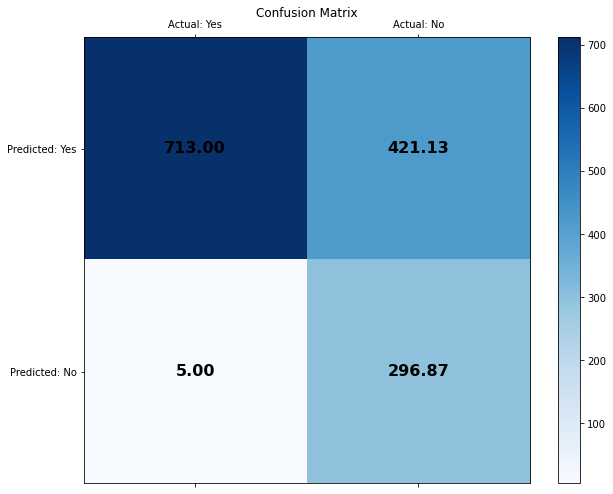

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x2 confusion matrix
confusion_mat = np.array([[tp, fp], [fn, tn]])

# Create a heatmap
plt.figure(figsize=(10, 8))
plt.matshow(confusion_mat, cmap='Blues', fignum=1)

# Add colorbar
plt.colorbar()

# Add annotations
for (i, j), z in np.ndenumerate(confusion_mat):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=16, color='black', weight='bold')

# Add labels to the plot
plt.title('Confusion Matrix', pad=20)
plt.xticks([0, 1], ['Actual: Yes', 'Actual: No'])
plt.yticks([0, 1], ['Predicted: Yes', 'Predicted: No'])

# Show the plot
plt.show()

In [19]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calculate the True Positive Rate (TPR), also known as recall
tpr = tp / (tp + fn)
print(f'True Positive Rate (TPR): {tpr:.2f}')

# Calculate the False Positive Rate (FPR)
fpr = fp / (fp + tn)
print(f'False Positive Rate (FPR): {fpr:.2f}')

# Calculate the Precision
precision = precision_score(y_true, y_pred)
print(f'Precision: {precision:.2f}')

# Calculate the Recall
recall = recall_score(y_true, y_pred)
print(f'Recall: {recall:.2f}')

# Calculate the F1 score
f1 = f1_score(y_true, y_pred)
print(f'F1 Score: {f1:.2f}')

# Calculate the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.2f}')

True Positive Rate (TPR): 0.99
False Positive Rate (FPR): 0.59
Precision: 0.14
Recall: 0.99
F1 Score: 0.24
Accuracy: 0.46


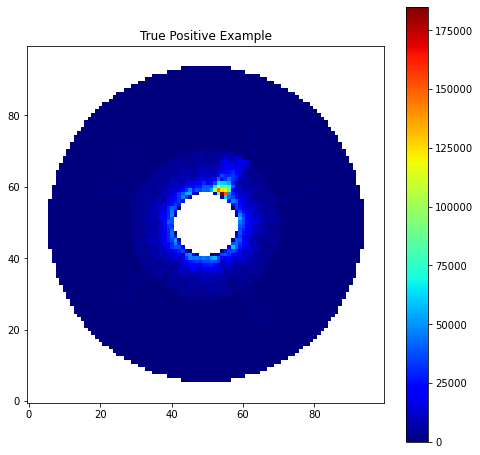

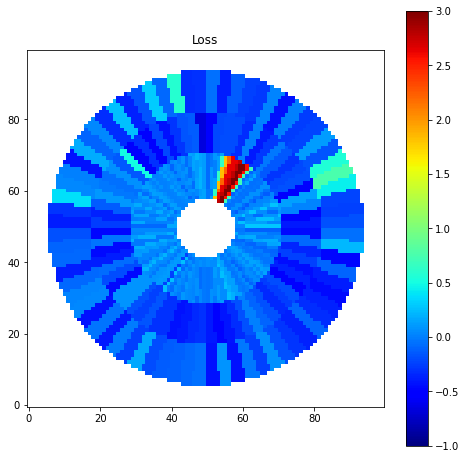

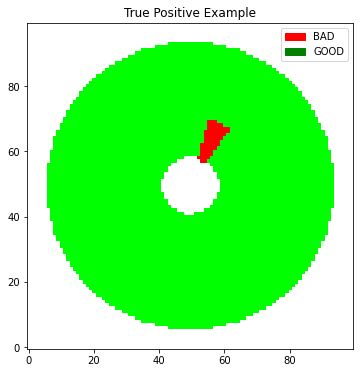

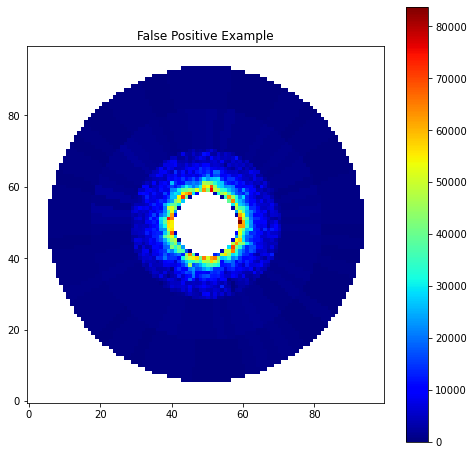

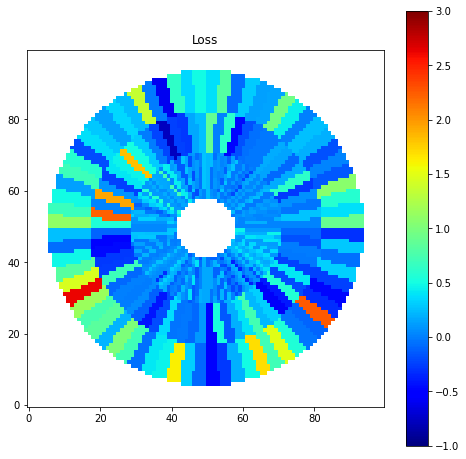

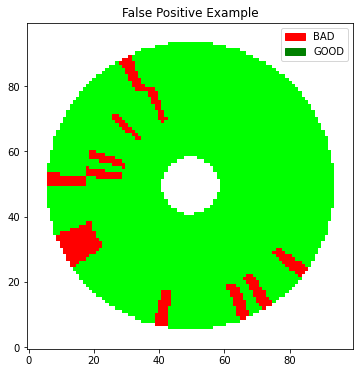

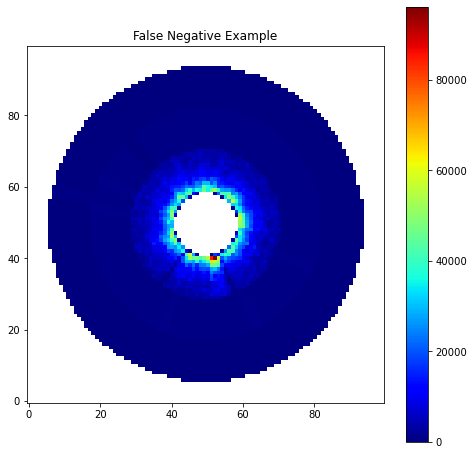

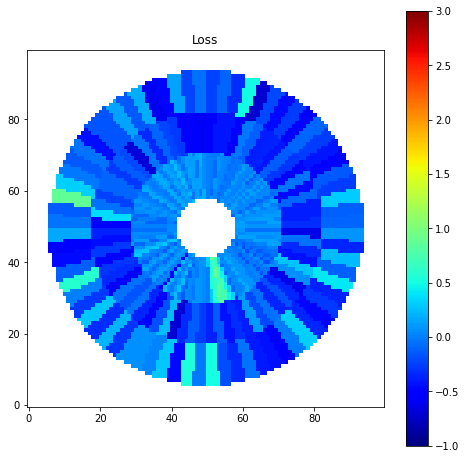

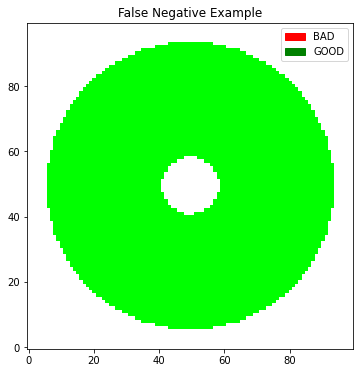

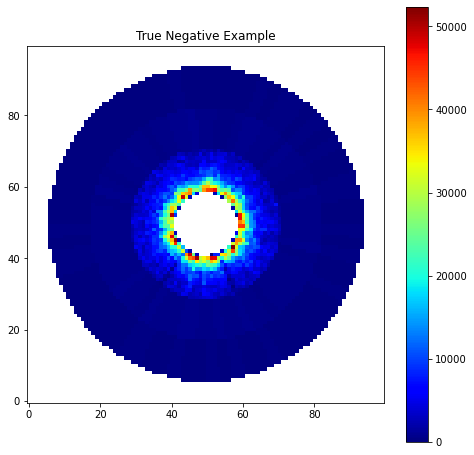

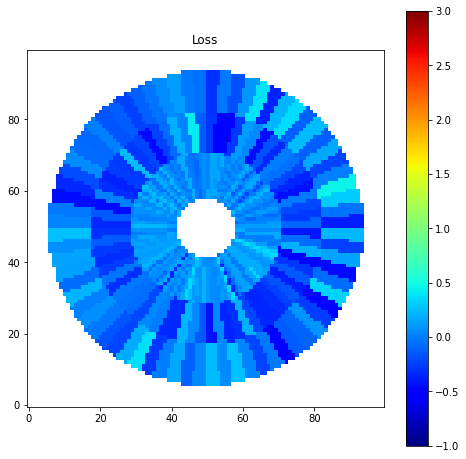

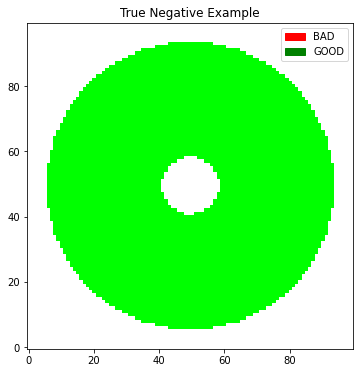

In [20]:
def process_and_plot_image(indices, title, index=0):
    _, img = mixed_dataset[indices[index]]
    img = img.unsqueeze(0).to(device)  
    reco_img = model(img)
    loss = img - reco_img
    loss = loss[0][0].detach().cpu().numpy()
    loss /= mean_matrix
    loss = rebin(inner_regions,loss)
    loss = rebin(regions,loss)

    img = img[0][0].detach().cpu().numpy()

    Show2Dimg(img, title = f"{title} Example")

    Show2DLoss(loss)
    loss = image_processor.process_image(loss)

    image_processor.plot_image(loss, title = f"{title} Example")

# Call the function for each of tp, fp, fn, tn
process_and_plot_image(tp_indices, "True Positive")
process_and_plot_image(fp_indices, "False Positive")
process_and_plot_image(fn_indices, "False Negative")
process_and_plot_image(tn_indices, "True Negative")